In [1]:
import torch
torch.manual_seed(123)

In [2]:
# Fastai is required by eb_ml_battery_lib
!pip install fastai==2.5.3 -q
# import
import pandas as pd
import numpy as np
import sys
from fastai.tabular import *
from fastai.tabular.all import *
# Load EB_ML python libraries
# The following libraries are used in this notebook and should be installed in your local machine before running this notebook.
# eb_colab_utils.py
# eb_ml_battery_lib.py
# eb_ml_utils.py

# path to load external *.py files used in this notebook
# Note: in Google Colab virtual machine you shoud copy the files in "/content" folder after BEFORE running this notebook's cell
external_python_file_path='../src'
sys.path.append(external_python_file_path)


from eb_ml_colab_utils import get_root_path
from eb_ml_battery_lib import load_soc_dataset,get_EIS_tabular_dataset_polar,get_EIS_tabular_dataset_rectangular
from eb_ml_utils import build_tabular_learner

In [3]:
#configuration dictionary
config ={}

# Root working folder (local or Google Drive)
# config['ROOT_DIR'] = get_root_path("batterie")
config['ROOT_DIR'] = get_root_path("..")  

# Folder with dataset in CSV format
#config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets"
config['DATASETS_DIR'] = config['ROOT_DIR']+"/datasets/EIS-vs-SOC-May2022"

# List of SoC level into dataset
#config['soc_list']=['100','090','080','070','060','050','040','030','020','010']
config['soc_list']=['100','090','080','070','060','050','040','030','020','010']

# Data acquisition files to load from dateset folder
battery_list=["02_4","02_5","02_6","02_7","02_8","02_9","03_4","03_5","03_6","03_7","03_8","03_9"]
dataset,feature_col_names=load_soc_dataset(battery_list,config["soc_list"],config['DATASETS_DIR'])

NOT running on COLAB


c:\gitrepos\ml-4-measurement\notebooks\../src\eb_ml_battery_lib.py:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset= dataset.append(df_rows)
c:\gitrepos\ml-4-measurement\notebooks\../src\eb_ml_battery_lib.py:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset= dataset.append(df_rows)
c:\gitrepos\ml-4-measurement\notebooks\../src\eb_ml_battery_lib.py:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset= dataset.append(df_rows)
c:\gitrepos\ml-4-measurement\notebooks\../src\eb_ml_battery_lib.py:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset= dataset.append(df_rows)
c:\gitrepos\ml-4-measurement\notebooks\.

## Regression - Tabular Learner - Polar 

In [4]:
dataset_polar,feature_col_names_polar=get_EIS_tabular_dataset_polar(dataset,feature_col_names)
splits = RandomSplitter(valid_pct=0.2)(range_of(dataset_polar))

In [5]:
#Path / default location for saving/loading models
model_path = '../models'

#The dependent variable/target
dep_var = 'SOC_float'

#The list of categorical features in the dataset
#cat_names = ['BATTERY_ID', 'EIS_ID'] 
cat_names = [] 

#List of Processes/transforms to be applied to the dataset
procs = [FillMissing, Categorify, Normalize]


In [7]:
learn = build_tabular_learner(dataset_polar,splits,model_path,dep_var,cat_names,feature_col_names_polar)

SuggestedLRs(valley=0.03981071710586548)

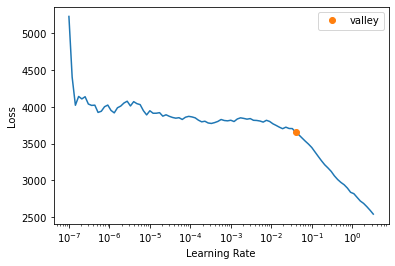

In [8]:
lr_value=learn.lr_find()
lr_value

In [9]:
learn.fit_one_cycle(250,lr_value)

epoch,train_loss,valid_loss,_rmse,time
0,1035.873291,629.318848,25.086226,00:06
1,42.564342,5.830486,2.414640,00:08
2,34.268051,5.211730,2.282921,00:07
3,32.764042,4.087989,2.021877,00:07
4,26.808933,4.128237,2.031806,00:08
5,32.239288,4.790211,2.188655,00:06
6,32.730427,2.449129,1.564969,00:05
7,34.616917,4.468908,2.113980,00:05
8,36.144325,3.645781,1.909393,00:06
9,32.804810,3.303144,1.817455,00:06


In [10]:
learn.show_results()

,Z_f0_phi,Z_f0_abs,Z_f1_phi,Z_f1_abs,Z_f2_phi,Z_f2_abs,Z_f3_phi,Z_f3_abs,Z_f4_phi,Z_f4_abs,Z_f5_phi,Z_f5_abs,Z_f6_phi,Z_f6_abs,Z_f7_phi,Z_f7_abs,Z_f8_phi,Z_f8_abs,Z_f9_phi,Z_f9_abs,Z_f10_phi,Z_f10_abs,Z_f11_phi,Z_f11_abs,Z_f12_phi,Z_f12_abs,Z_f13_phi,Z_f13_abs,SOC_float,SOC_float_pred
0,-0.477251,-1.437332,-0.575913,-0.869335,-0.627243,-1.222211,-0.700619,-0.711441,-0.773141,-0.182497,-0.838865,-0.129923,-0.873275,0.039533,-0.866174,-0.072847,-0.866748,-0.362707,-0.885262,-0.692727,-0.922380,-1.043810,-0.940961,-1.280804,-0.806003,-1.269646,-0.842398,-1.132193,80.0,77.498604
1,-0.878954,1.287694,-0.738055,1.425067,-0.691371,1.489916,-0.588482,1.267884,-0.491284,0.998987,-0.459951,0.864209,-0.356121,0.726803,-0.249653,0.743855,-0.164505,0.502807,-0.048010,0.085968,0.380598,0.112880,0.541692,-0.060017,0.689160,0.135691,0.729910,-0.414313,40.0,39.417084
2,-0.442030,-0.149300,-0.283754,0.762908,-0.118323,0.583899,-0.147277,0.565978,-0.073848,0.403225,-0.035854,0.323271,0.038268,0.357052,0.073358,-0.147878,0.019894,-0.427293,0.101701,-0.292438,0.223834,-0.519472,0.411115,-0.809524,0.357566,-0.884445,0.257627,-1.560404,100.0,96.773483
3,-0.249560,-0.510943,-0.273066,-0.259802,-0.323544,-0.365612,-0.384989,-0.088724,-0.327465,0.131002,-0.350379,0.320989,-0.280746,0.367920,-0.146593,0.493708,-0.126087,0.676800,0.007538,0.812100,0.037588,0.833745,0.088515,0.853166,0.096551,0.855523,0.066918,-0.013399,90.0,87.335548
4,2.512842,-0.586399,2.485663,-0.816117,2.457917,-1.838536,2.444643,-2.681859,2.336734,-3.642802,2.156741,-3.786598,1.718634,-3.376893,1.233698,-2.117034,1.185061,-0.962628,1.369115,-0.025212,1.603434,0.733810,1.759067,0.729447,1.659740,0.718069,1.615527,0.325418,10.0,10.960859
5,0.210463,-1.513047,0.072484,-1.389515,0.014827,-1.133761,-0.051309,-1.188785,-0.132340,-0.187955,-0.126320,0.027042,-0.259259,0.015563,-0.112626,0.205156,-0.060932,-0.319817,-0.174231,-0.640310,-0.591301,-0.945577,-0.745293,-0.960176,-0.784771,-0.674552,-0.825983,-0.594514,70.0,67.790123
6,-0.297436,-0.546456,-0.292664,-0.421826,-0.331265,-0.194040,-0.361336,-0.223300,-0.399341,0.110460,-0.384283,0.273817,-0.402191,0.457372,-0.290524,0.693220,-0.270800,0.498164,-0.297454,0.542180,-0.523611,0.597015,-0.555858,0.701595,-0.642019,0.533980,-0.645684,0.512881,90.0,87.248085
7,-0.360357,-0.763791,-0.366122,-0.561670,-0.421063,-0.489998,-0.437912,-0.589634,-0.482051,-0.072852,-0.486666,0.095039,-0.490176,0.089641,-0.503826,0.215367,-0.452712,-0.178566,-0.428712,-0.202685,-0.140210,-0.518896,-0.025767,-0.792033,0.085217,-0.845770,0.138526,-0.304765,90.0,87.042297
8,0.381451,-0.540960,0.124995,-1.409972,-0.062468,-0.839282,-0.000280,-0.173432,-0.092938,0.221942,-0.097629,0.581428,-0.058036,0.659848,0.202779,0.841897,0.283927,0.926036,0.461743,0.561245,0.462097,0.553520,0.417896,0.305441,0.331289,0.909322,0.308753,0.155059,60.0,58.769035


In [15]:
from sklearn.metrics import mean_squared_error
[y_pred,y_true] =learn.get_preds()
mean_squared_error(y_true,y_pred,squared=False)


1.8371267

In [11]:
learn.save('EIS_tabular_regression')

Path('../models/models/EIS_tabular_regression.pth')

# Tabular Learner Regression - Rectangular

In [17]:
dataset_rect,feature_col_names_rect=get_EIS_tabular_dataset_rectangular(dataset,feature_col_names)
splits = RandomSplitter(valid_pct=0.2)(range_of(dataset_polar))

In [18]:
#Path / default location for saving/loading models
model_path = '../models'

#The dependent variable/target
dep_var = 'SOC_float'

#The list of categorical features in the dataset
#cat_names = ['BATTERY_ID', 'EIS_ID'] 
cat_names = [] 

#List of Processes/transforms to be applied to the dataset
procs = [FillMissing, Categorify, Normalize]

In [22]:
dataset_rect,feature_col_names_rect=get_EIS_tabular_dataset_rectangular(dataset,feature_col_names)
learn = build_tabular_learner(dataset_rect,splits,model_path,dep_var,cat_names=[],cont_names=feature_col_names_rect)

SuggestedLRs(valley=0.02290867641568184)

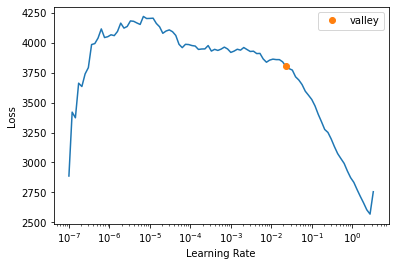

In [23]:
lr_value=learn.lr_find()
lr_value

In [24]:
learn.fit_one_cycle(250,0.045)



epoch,train_loss,valid_loss,_rmse,time
0,722.992615,393.941071,19.847946,00:09
1,36.025883,5.915266,2.432132,00:08
2,52.202316,6.506876,2.550858,00:10
3,30.948372,3.623622,1.903581,00:11
4,32.884068,4.796424,2.190074,00:06
5,35.348015,3.254991,1.804159,00:06
6,35.521957,6.500465,2.549601,00:06
7,30.685995,3.709247,1.925941,00:06
8,30.698692,2.890879,1.700258,00:06
9,30.750444,2.345696,1.531567,00:06


In [25]:
learn.show_results()

,Z_f0_real,Z_f0_imag,Z_f1_real,Z_f1_imag,Z_f2_real,Z_f2_imag,Z_f3_real,Z_f3_imag,Z_f4_real,Z_f4_imag,Z_f5_real,Z_f5_imag,Z_f6_real,Z_f6_imag,Z_f7_real,Z_f7_imag,Z_f8_real,Z_f8_imag,Z_f9_real,Z_f9_imag,Z_f10_real,Z_f10_imag,Z_f11_real,Z_f11_imag,Z_f12_real,Z_f12_imag,Z_f13_real,Z_f13_imag,SOC_float,SOC_float_pred
0,-0.279216,1.250718,-0.117414,0.895794,-0.111171,0.758876,-0.079801,0.952863,0.007958,0.255465,0.058177,0.087735,0.020339,0.062469,-0.015879,0.050934,0.103160,0.642321,0.167588,0.869669,0.585514,1.060099,0.911171,1.292834,1.021401,1.198199,1.036059,0.576297,20.0,22.843376
1,-0.606887,-0.729326,-0.659498,-0.633142,-0.692880,-0.635084,-0.783670,-0.222766,-0.833578,0.120419,-0.876179,0.325266,-0.939833,0.644200,-1.023919,0.834383,-0.949428,0.975544,-0.740206,0.978341,-0.374494,0.681578,-0.216159,0.827400,-0.028062,0.706233,0.159499,0.878719,80.0,79.565948
2,-0.705812,-1.629364,-0.782066,-1.391399,-0.885362,-1.267863,-0.914017,-0.795234,-1.005664,-0.307938,-1.085092,-0.054762,-1.167686,-0.052201,-1.213956,0.359309,-1.195378,0.286130,-0.868562,-0.120885,-0.587074,-0.311232,-0.252297,-0.394109,-0.037955,-0.538943,0.120542,0.868482,70.0,70.335770
3,-1.138307,1.432919,-1.025199,1.342805,-0.933331,1.184591,-0.903155,1.294221,-0.827915,0.844158,-0.808358,0.696299,-0.745247,0.768193,-0.683938,0.714576,-0.677239,0.524501,-0.550596,0.095572,-0.401434,-0.023163,-0.387516,0.093089,-0.334662,0.212521,-0.274693,-0.013894,40.0,41.754292
4,0.635214,-0.605804,0.573315,-0.452797,0.551564,-0.342438,0.563414,-0.212684,0.545110,0.095626,0.635799,0.190494,0.684594,-0.089114,0.843928,-0.231023,1.307275,-0.777511,1.072860,-0.931525,0.892052,-1.222183,0.651729,-1.042909,0.398937,-1.125976,0.325399,-1.765001,90.0,89.302948
5,-0.547527,1.290060,-0.466722,1.056024,-0.388491,1.126430,-0.331158,0.807207,-0.224487,0.731905,-0.139918,0.451240,-0.023984,0.440616,-0.028356,0.043033,-0.000027,-0.040557,-0.081187,0.059661,-0.192596,-0.214056,-0.215990,-0.316682,-0.308518,-0.062494,-0.227714,-0.068189,30.0,32.556492
6,2.118576,-1.398738,2.080022,-1.288755,2.010631,-1.945440,1.960399,-2.188982,1.842645,-2.595567,1.633246,-2.669206,1.241561,-2.787051,0.588022,-2.939952,0.372169,-2.688913,0.557667,-1.996522,0.630485,-1.458547,0.613568,-1.539823,0.611379,-0.985929,0.572810,-0.813998,10.0,13.582905
7,-0.470288,1.057795,-0.391274,1.016299,-0.304393,0.879511,-0.308849,0.899267,-0.321659,0.650100,-0.221642,0.628279,-0.026083,0.609313,0.008580,0.909280,0.075292,1.160910,-0.124316,0.925774,-0.341973,0.648814,-0.572905,0.903327,-0.527499,0.611793,-0.590128,1.488865,50.0,51.429073
8,-1.131870,1.490423,-1.019394,1.395140,-0.952751,1.316443,-0.886433,1.320398,-0.894621,1.011299,-0.889506,0.810168,-0.777132,0.710264,-0.990285,0.921484,-0.936073,0.746033,-0.996068,0.919864,-0.773080,1.095504,-0.601005,0.991998,-0.693881,1.182684,-0.518593,0.870956,40.0,41.686134


In [26]:
from sklearn.metrics import mean_squared_error
[y_pred,y_true] =learn.get_preds()
mean_squared_error(y_true,y_pred,squared=False)

1.9006441

In [27]:
learn.save('EIS_tabular_regression_rect')

Path('../models/models/EIS_tabular_regression_rect.pth')

In [28]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=28, out_features=300, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=300, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0

In [ ]:
learn.summary()